In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Source

In [ ]:
from pathlib import Path
data_path = Path('/content/drive/MyDrive/FacialAge/Data')
model_path = Path('/content/drive/MyDrive/FacialAge/Model')

# Preprocessing

## Parameter

In [ ]:
width = height = 224
img_size = (width, height)
img_shape = img_size + (3, )
batch_size = 32 
initial_epochs = 50
fine_tune_epochs = 50
seed = 10
learning_rate = 1e-4
results = {}

## Load data
70% train, 15% test, 15% val

### Train Dataset

In [ ]:
from tensorflow.data.experimental import cardinality
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(
                                      data_path,
                                      labels="inferred",
                                      label_mode="int",
                                      class_names=None,
                                      seed=seed,
                                      image_size=img_size,
                                      smart_resize=True,
                                      batch_size=batch_size)
temp_ds = train_ds
train_batches = cardinality(train_ds)

Found 9778 files belonging to 99 classes.


In [ ]:
class_names = train_ds.class_names
num_class = len(class_names)
print(num_class,' : ', class_names)

99  :  ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '095', '096', '099', '100', '101', '110']


### Test Dataset

In [ ]:
test_ds = train_ds.take(train_batches // 20 * 3)
train_ds = train_ds.skip(train_batches // 20 * 3)

### Val Dataset

In [ ]:
val_ds = train_ds.take(train_batches // 20 * 3)
train_ds = train_ds.skip(train_batches // 20 * 3)

## Data Visualization

### Overview

In [ ]:
import os
import numpy as np
labels = []
files = []
for a in os.walk(data_path):
    labels = a[1]
    break
for a in os.walk(data_path):
    files.append(len(a[2]))
files.remove(0)
a = []
for i in range(99):
    a. append([int(labels[i]),files[i]]) 
num_class = len(labels)
num_files = sum(files)
a.sort()
a = np.array(a)

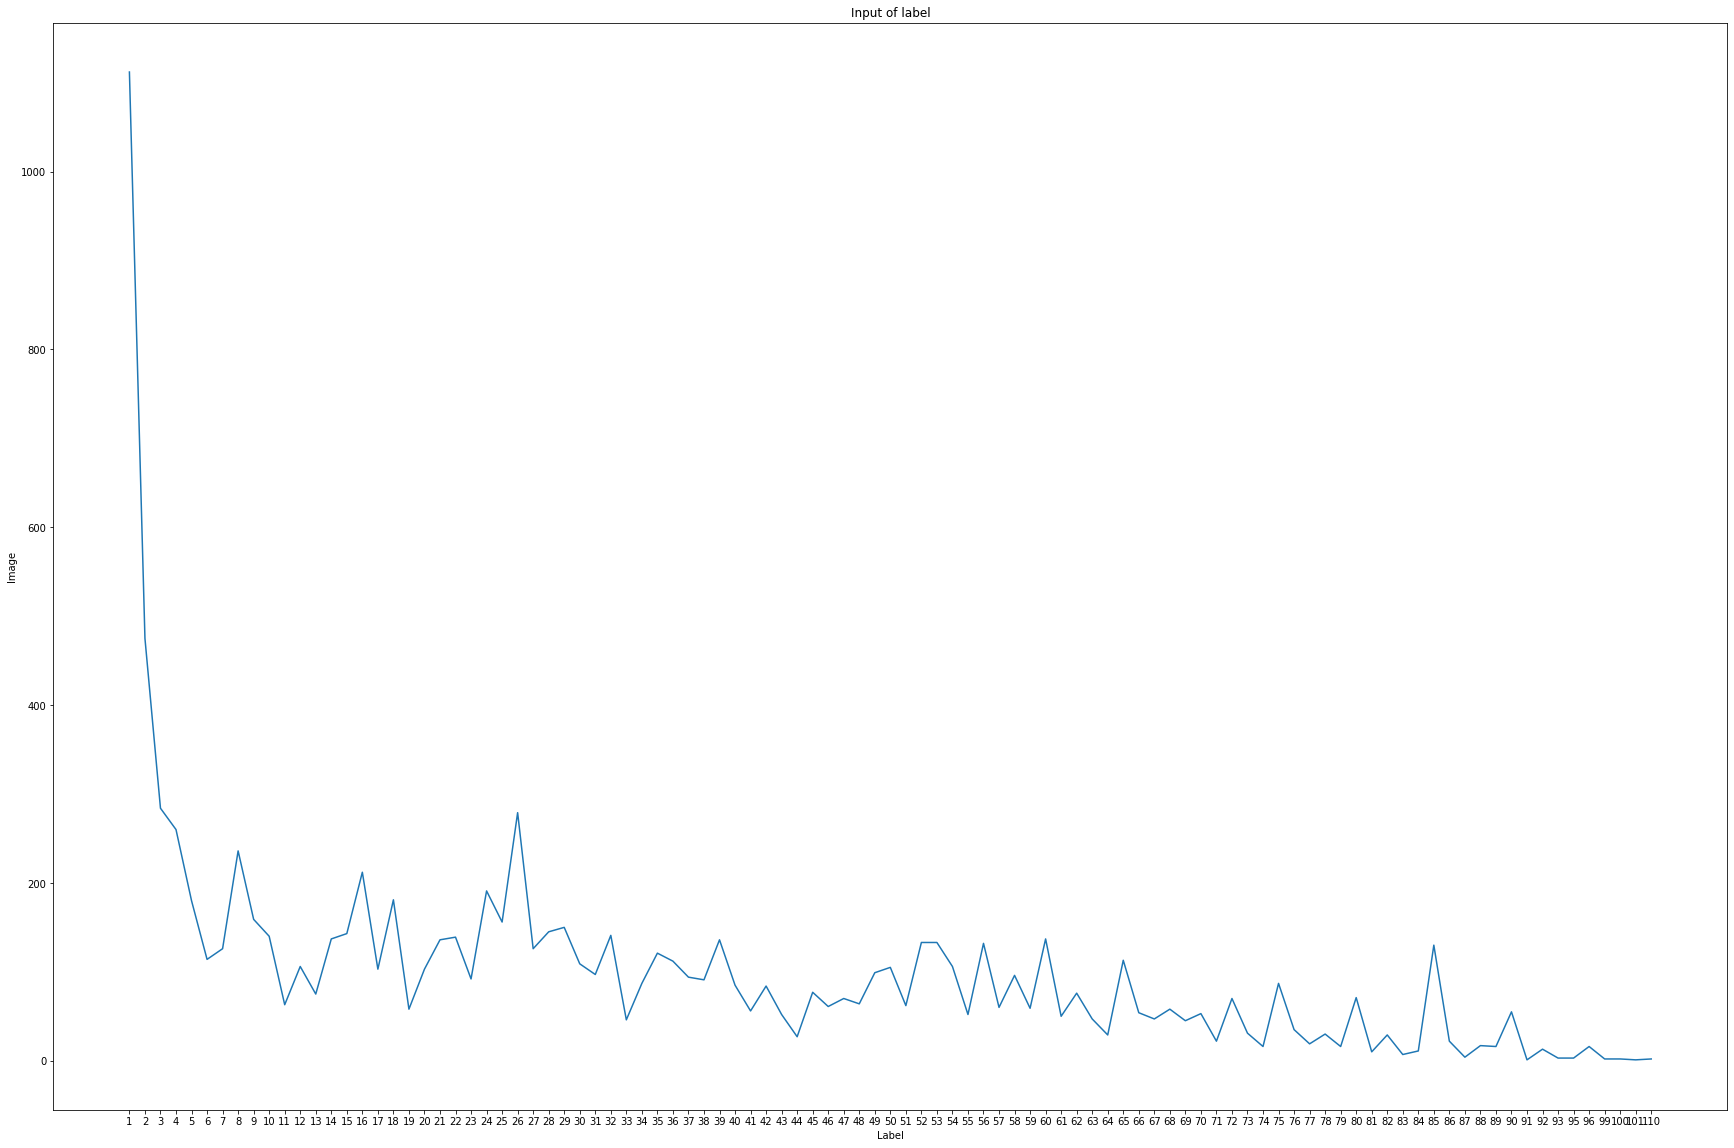

In [ ]:
import matplotlib.pyplot as plt
X = a[:,0]
Y = a[:,1]
X_axis = np.arange(len(X))
plt.figure(figsize=(30,20))  
plt.plot(X_axis , Y, 0.4)
plt.xticks(X_axis, X)
plt.xlabel("Label")
plt.ylabel("Image")
plt.title("Input of label")
plt.show()

### Example

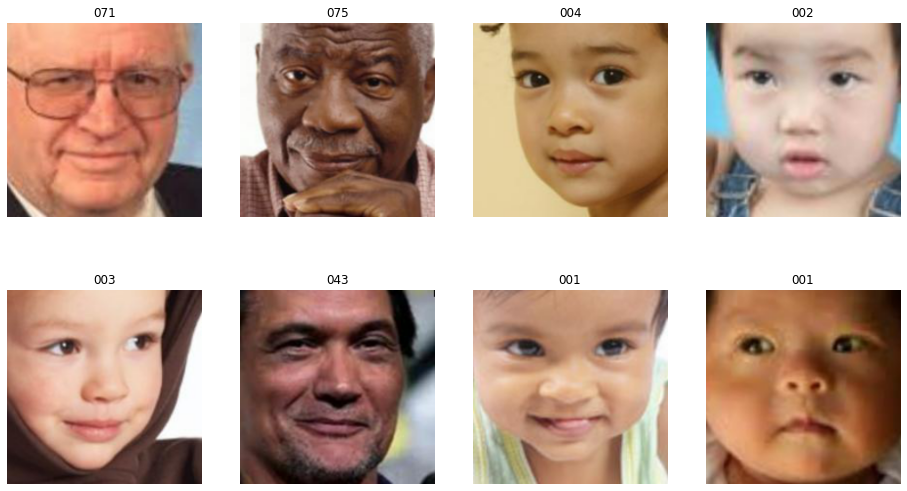

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
images, labels = next(iter(temp_ds))
for i in range(8):
  ax = plt.subplot(2, 4, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(temp_ds.class_names[labels[i]])
  plt.axis("off")

## Data augment

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape = img_shape),
    RandomRotation(0.1),
    RandomZoom(-0.1,0.1),
  ]
)

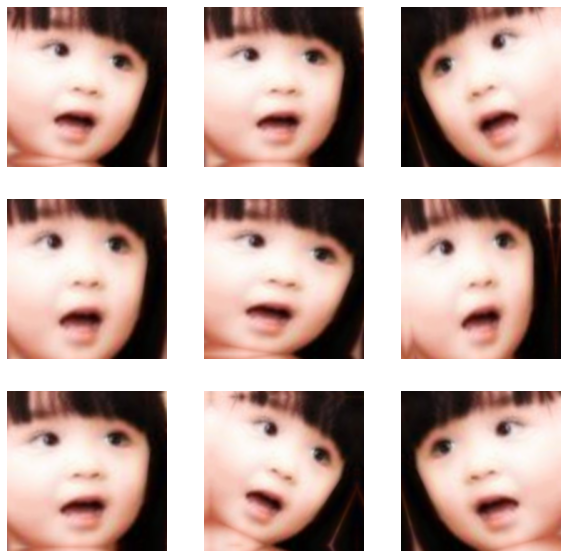

In [ ]:
import tensorflow as tf
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Data Performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Call Back 

In [ ]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=5, # wait for 5 epochs
                                min_delta = 0.01, # if in 5 epochs the loss function doesn't inrease (for accuracy) 
                                               # or decrease (for val_loss) by 1%, then stop
                                verbose=1, # print the training epoch on which training was stopped
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=1, # if val_loss plateaus for 1 epochs such that it doesn't see 
                                                # an improvement of size = epsilon
                                    episilon= 0.01,
                                    factor=0.1,  # then we reduce the learning rate by a factor of 0.1
                                    cooldown = 4, # and we wait for 4 epochs before we restart again
                                    verbose=1)

time_callback = TimingCallback()

#Model

## MobileNet V1

### Base Model

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

# download model MobileNet V1
base_model_V1 = MobileNet(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_V1.trainable = False

17227776/17225924 [==============================] - 0s 0us/step


### Build Model

In [ ]:
inputs = Input(shape=img_shape, dtype = tf.uint8)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model_V1(x, training=False) 
x = GlobalAveragePooling2D(input_shape=img_shape)(x)
x = Dropout(0.2)(x)  
x = Dense(256, activation="tanh")(x)
outputs = Dense(1, activation="linear")(x)

# Final model
model_V1 = Model(inputs, outputs)
model_V1.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0     

In [ ]:
model_V1_history = model_V1.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/50
216/216 [==============================] - 804s 4s/step - loss: 20.5279 - mean_absolute_error: 20.5279 - val_loss: 18.1208 - val_mean_absolute_error: 18.1208
Epoch 2/50
216/216 [==============================] - 9s 44ms/step - loss: 16.2783 - mean_absolute_error: 16.2783 - val_loss: 15.3854 - val_mean_absolute_error: 15.3854
Epoch 3/50
216/216 [==============================] - 9s 43ms/step - loss: 14.5844 - mean_absolute_error: 14.5844 - val_loss: 14.1035 - val_mean_absolute_error: 14.1035
Epoch 4/50
216/216 [==============================] - 9s 43ms/step - loss: 13.5088 - mean_absolute_error: 13.5088 - val_loss: 13.1462 - val_mean_absolute_error: 13.1462
Epoch 5/50
216/216 [==============================] - 9s 44ms/step - loss: 12.7141 - mean_absolute_error: 12.7141 - val_loss: 12.4574 - val_mean_absolute_error: 12.4574
Epoch 6/50
216/216 [==============================] - 9s 44ms/step - loss: 12.1057 - mean_absolute_error: 12.1057 - val_loss: 11.9327 - val_mean_absolute_e

### Tranfer Learning

In [ ]:
base_model_V1.trainable = True

In [ ]:
len(base_model_V1.layers)

86

In [ ]:
ft_at = 10
for layer in base_model_V1.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_V1.layers[ft_at:]:
    layer.trainable = True
model_V1.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V1_fn = model_V1.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_V1_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 32/100
216/216 [==============================] - 35s 142ms/step - loss: 12.3042 - mean_absolute_error: 12.3042 - val_loss: 9.7292 - val_mean_absolute_error: 9.7292
Epoch 33/100
216/216 [==============================] - 30s 139ms/step - loss: 8.5841 - mean_absolute_error: 8.5841 - val_loss: 7.4620 - val_mean_absolute_error: 7.4620
Epoch 34/100
216/216 [==============================] - 30s 139ms/step - loss: 7.8064 - mean_absolute_error: 7.8064 - val_loss: 8.8667 - val_mean_absolute_error: 8.8667

Epoch 00034: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 35/100
216/216 [==============================] - 30s 139ms/step - loss: 6.8422 - mean_absolute_error: 6.8422 - val_loss: 6.3046 - val_mean_absolute_error: 6.3046
Epoch 36/100
216/216 [==============================] - 30s 139ms/step - loss: 6.3534 - mean_absolute_error: 6.3534 - val_loss: 6.1228 - val_mean_absolute_error: 6.1228
Epoch 37/100
216/216 [==============================] - 30s 139ms/step -

In [ ]:
model_V1_train_loss = model_V1_fn.history["loss"]
model_V1_val_loss = model_V1_fn.history["val_loss"]
model_V1_train_acc = model_V1_fn.history["mean_absolute_error"]
model_V1_val_acc = model_V1_fn.history["val_mean_absolute_error"]

results["model_V1"] = {'train-loss': model_V1_train_loss,
                             'val-loss': model_V1_val_loss,
                             'train-mae': model_V1_train_acc,
                             'val-mae': model_V1_val_acc}

## MobileNet V2

### Base Model

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# download model MobileNet V2
base_model_V2 = MobileNetV2(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_V2.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


### Build Model

In [ ]:
inputs = Input(shape=img_shape, dtype = tf.uint8)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model_V2(x, training=False) 
x = GlobalAveragePooling2D(input_shape=img_shape)(x)
x = Dropout(0.2)(x)  
x = Dense(256, activation="tanh")(x)
outputs = Dense(1, activation="linear")(x)

# Final model
model_V2 = Model(inputs, outputs)
model_V2.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [ ]:
model_V2_history = model_V2.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/50
216/216 [==============================] - 15s 55ms/step - loss: 19.5396 - mean_absolute_error: 19.5396 - val_loss: 17.1024 - val_mean_absolute_error: 17.1024
Epoch 2/50
216/216 [==============================] - 11s 50ms/step - loss: 15.8108 - mean_absolute_error: 15.8108 - val_loss: 15.2470 - val_mean_absolute_error: 15.2470
Epoch 3/50
216/216 [==============================] - 11s 50ms/step - loss: 14.3384 - mean_absolute_error: 14.3384 - val_loss: 14.1384 - val_mean_absolute_error: 14.1384
Epoch 4/50
216/216 [==============================] - 11s 50ms/step - loss: 13.3919 - mean_absolute_error: 13.3919 - val_loss: 13.3817 - val_mean_absolute_error: 13.3817
Epoch 5/50
216/216 [==============================] - 11s 50ms/step - loss: 12.7691 - mean_absolute_error: 12.7691 - val_loss: 12.7938 - val_mean_absolute_error: 12.7938
Epoch 6/50
216/216 [==============================] - 11s 50ms/step - loss: 12.1971 - mean_absolute_error: 12.1971 - val_loss: 12.3510 - val_mean_abso

### Tranfer Learning

In [ ]:
base_model_V2.trainable = True

In [ ]:
len(base_model_V2.layers)

154

In [ ]:
ft_at = 30
for layer in base_model_V2.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_V2.layers[ft_at:]:
    layer.trainable = True
model_V2.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V2_fn = model_V2.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_V2_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 35/100
216/216 [==============================] - 27s 106ms/step - loss: 9.7337 - mean_absolute_error: 9.7337 - val_loss: 7.7664 - val_mean_absolute_error: 7.7664
Epoch 36/100
216/216 [==============================] - 22s 100ms/step - loss: 7.5047 - mean_absolute_error: 7.5047 - val_loss: 6.5540 - val_mean_absolute_error: 6.5540
Epoch 37/100
216/216 [==============================] - 22s 101ms/step - loss: 6.6145 - mean_absolute_error: 6.6145 - val_loss: 5.7448 - val_mean_absolute_error: 5.7448
Epoch 38/100
216/216 [==============================] - 22s 100ms/step - loss: 6.1684 - mean_absolute_error: 6.1684 - val_loss: 5.8734 - val_mean_absolute_error: 5.8734

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 39/100
216/216 [==============================] - 22s 101ms/step - loss: 5.3048 - mean_absolute_error: 5.3048 - val_loss: 5.3103 - val_mean_absolute_error: 5.3103
Epoch 40/100
216/216 [==============================] - 22s 101ms/step - l

In [ ]:
model_V2_train_loss = model_V2_fn.history["loss"]
model_V2_val_loss = model_V2_fn.history["val_loss"]
model_V2_train_acc = model_V2_fn.history["mean_absolute_error"]
model_V2_val_acc = model_V2_fn.history["val_mean_absolute_error"]

results["model_V2"] = {'train-loss': model_V2_train_loss,
                             'val-loss': model_V2_val_loss,
                             'train-mae': model_V2_train_acc,
                             'val-mae': model_V2_val_acc}

## MobileNet V3L

### Base Model

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# download model MobileNet V3L
base_model_V3L = MobileNetV3Large(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_V3L.trainable = False

17612800/17605208 [==============================] - 0s 0us/step


### Build Model

In [ ]:
inputs = Input(shape=img_shape, dtype = tf.uint8)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model_V3L(x, training=False)
x = GlobalAveragePooling2D(input_shape=img_shape)(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="tanh")(x)
outputs = Dense(1, activation="linear")(x)

# Final model
model_V3L = Model(inputs, outputs)
model_V3L.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V3L.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               327936    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257 

In [ ]:
model_V3L_history = model_V3L.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/50
216/216 [==============================] - 16s 54ms/step - loss: 19.0217 - mean_absolute_error: 19.0217 - val_loss: 16.3953 - val_mean_absolute_error: 16.3953
Epoch 2/50
216/216 [==============================] - 10s 48ms/step - loss: 15.3115 - mean_absolute_error: 15.3115 - val_loss: 14.4227 - val_mean_absolute_error: 14.4227
Epoch 3/50
216/216 [==============================] - 10s 48ms/step - loss: 13.8592 - mean_absolute_error: 13.8592 - val_loss: 13.3440 - val_mean_absolute_error: 13.3440
Epoch 4/50
216/216 [==============================] - 10s 48ms/step - loss: 13.0027 - mean_absolute_error: 13.0027 - val_loss: 12.5281 - val_mean_absolute_error: 12.5281
Epoch 5/50
216/216 [==============================] - 10s 48ms/step - loss: 12.2942 - mean_absolute_error: 12.2942 - val_loss: 11.8736 - val_mean_absolute_error: 11.8736
Epoch 6/50
216/216 [==============================] - 10s 48ms/step - loss: 11.7847 - mean_absolute_error: 11.7847 - val_loss: 11.3994 - val_mean_abso

### Tranfer Learning

In [ ]:
base_model_V3L.trainable = True

In [ ]:
len(base_model_V3L.layers)

276

In [ ]:
ft_at = 30
for layer in base_model_V3L.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_V3L.layers[ft_at:]:
    layer.trainable = True
model_V3L.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V3L_fn = model_V3L.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_V3L_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 32/100
216/216 [==============================] - 32s 122ms/step - loss: 7.9420 - mean_absolute_error: 7.9420 - val_loss: 6.4330 - val_mean_absolute_error: 6.4330
Epoch 33/100
216/216 [==============================] - 25s 116ms/step - loss: 6.4897 - mean_absolute_error: 6.4897 - val_loss: 5.7294 - val_mean_absolute_error: 5.7294
Epoch 34/100
216/216 [==============================] - 25s 116ms/step - loss: 5.9172 - mean_absolute_error: 5.9172 - val_loss: 5.9210 - val_mean_absolute_error: 5.9210

Epoch 00034: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 35/100
216/216 [==============================] - 25s 115ms/step - loss: 5.2092 - mean_absolute_error: 5.2092 - val_loss: 5.3858 - val_mean_absolute_error: 5.3858
Epoch 36/100
216/216 [==============================] - 25s 115ms/step - loss: 5.0296 - mean_absolute_error: 5.0296 - val_loss: 5.3406 - val_mean_absolute_error: 5.3406
Epoch 37/100
216/216 [==============================] - 25s 115ms/step - l

In [ ]:
model_V3L_train_loss = model_V3L_fn.history["loss"]
model_V3L_val_loss = model_V3L_fn.history["val_loss"]
model_V3L_train_acc = model_V3L_fn.history["mean_absolute_error"]
model_V3L_val_acc = model_V3L_fn.history["val_mean_absolute_error"]

results["model_V3L"] = {'train-loss': model_V3L_train_loss,
                             'val-loss': model_V3L_val_loss,
                             'train-mae': model_V3L_train_acc,
                             'val-mae': model_V3L_val_acc}

## MobileNet V3S

### Base Model

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# download model MobileNet V3S
base_model_V3S = MobileNetV3Small(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_V3S.trainable = False

6701056/6698480 [==============================] - 0s 0us/step


### Build Model

In [ ]:
inputs = Input(shape=img_shape, dtype = tf.uint8)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model_V3S(x, training=False)
x = GlobalAveragePooling2D(input_shape=img_shape)(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="tanh")(x)
outputs = Dense(1, activation="linear")(x)

# Final model
model_V3S = Model(inputs, outputs)
model_V3S.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V3S.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257 

In [ ]:
model_V3S_history = model_V3S.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/50
216/216 [==============================] - 10s 31ms/step - loss: 20.3388 - mean_absolute_error: 20.3388 - val_loss: 17.8361 - val_mean_absolute_error: 17.8361
Epoch 2/50
216/216 [==============================] - 6s 26ms/step - loss: 16.2543 - mean_absolute_error: 16.2543 - val_loss: 15.1319 - val_mean_absolute_error: 15.1319
Epoch 3/50
216/216 [==============================] - 6s 26ms/step - loss: 14.5665 - mean_absolute_error: 14.5665 - val_loss: 13.8846 - val_mean_absolute_error: 13.8846
Epoch 4/50
216/216 [==============================] - 6s 26ms/step - loss: 13.5198 - mean_absolute_error: 13.5198 - val_loss: 13.0512 - val_mean_absolute_error: 13.0512
Epoch 5/50
216/216 [==============================] - 6s 26ms/step - loss: 12.8150 - mean_absolute_error: 12.8150 - val_loss: 12.4139 - val_mean_absolute_error: 12.4139
Epoch 6/50
216/216 [==============================] - 6s 27ms/step - loss: 12.2952 - mean_absolute_error: 12.2952 - val_loss: 11.9456 - val_mean_absolute_

### Tranfer Learning

In [ ]:
base_model_V3S.trainable = True

In [ ]:
len(base_model_V3S.layers)

243

In [ ]:
ft_at = 30
for layer in base_model_V3S.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_V3S.layers[ft_at:]:
    layer.trainable = True
model_V3S.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V3S_fn = model_V3S.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_V3S_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 24/100
216/216 [==============================] - 18s 59ms/step - loss: 8.3184 - mean_absolute_error: 8.3184 - val_loss: 7.3756 - val_mean_absolute_error: 7.3756
Epoch 25/100
216/216 [==============================] - 12s 54ms/step - loss: 7.2817 - mean_absolute_error: 7.2817 - val_loss: 6.7194 - val_mean_absolute_error: 6.7194
Epoch 26/100
216/216 [==============================] - 12s 55ms/step - loss: 6.8154 - mean_absolute_error: 6.8154 - val_loss: 6.3966 - val_mean_absolute_error: 6.3966
Epoch 27/100
216/216 [==============================] - 12s 54ms/step - loss: 6.3903 - mean_absolute_error: 6.3903 - val_loss: 6.2461 - val_mean_absolute_error: 6.2461
Epoch 28/100
216/216 [==============================] - 12s 54ms/step - loss: 6.0003 - mean_absolute_error: 6.0003 - val_loss: 6.0486 - val_mean_absolute_error: 6.0486
Epoch 29/100
216/216 [==============================] - 12s 54ms/step - loss: 5.8326 - mean_absolute_error: 5.8326 - val_loss: 5.8476 - val_mean_absolute_error:

In [ ]:
model_V3S_train_loss = model_V3S_fn.history["loss"]
model_V3S_val_loss = model_V3S_fn.history["val_loss"]
model_V3S_train_acc = model_V3S_fn.history["mean_absolute_error"]
model_V3S_val_acc = model_V3S_fn.history["val_mean_absolute_error"]

results["model_V3S"] = {'train-loss': model_V3S_train_loss,
                             'val-loss': model_V3S_val_loss,
                             'train-mae': model_V3S_train_acc,
                             'val-mae': model_V3S_val_acc}

# Save Model

In [ ]:
from tensorflow.keras.models import save_model

In [ ]:
#Save model format
save_model (model_V1 , model_path/'MobileNetV1')
save_model (model_V2 , model_path/'MobileNetV2')
save_model (model_V3L , model_path/'MobileNetV3L')
save_model (model_V3S , model_path/'MobileNetV3S')

#HDF5 format
save_model (model_V1 , model_path/'MobileNetV1.h5')
save_model (model_V2 , model_path/'MobileNetV2.h5')
save_model (model_V3L , model_path/'MobileNetV3L.h5')
save_model (model_V3S , model_path/'MobileNetV3S.h5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model/MobileNetV1/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model/MobileNetV2/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model/MobileNetV3L/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model/MobileNetV3S/assets


# Model Evaluation

## Model Performances

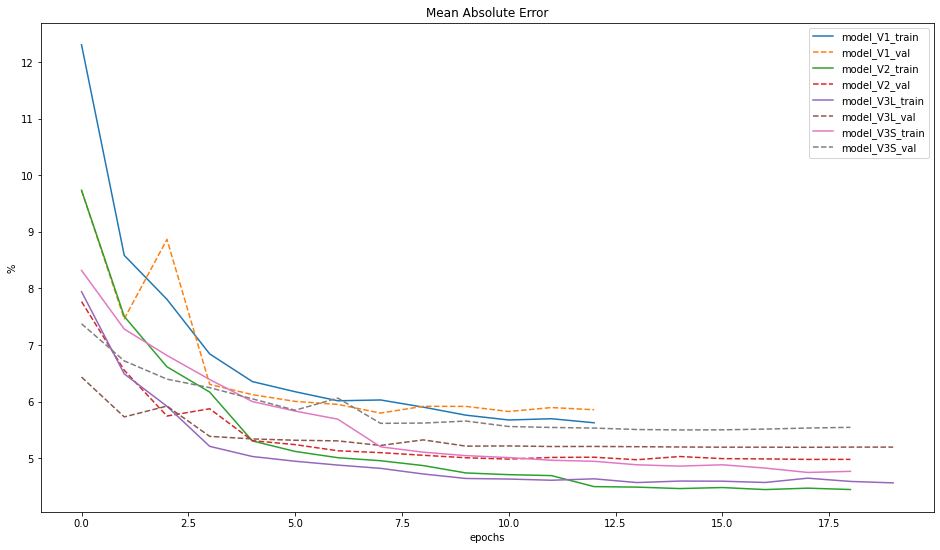

In [ ]:
color_bar = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(16,9))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-mae'])),results[cond]['train-mae'], '-', label=cond+"_train")
    plt.plot(range(len(results[cond]['val-mae'])),results[cond]['val-mae'], '--', label=cond+"_val")
plt.title("Mean Absolute Error")
plt.xlabel("epochs")
plt.ylabel("%")
plt.legend()
plt.show()
#Best of value is 0

## Evaluate performance on test set

In [ ]:
loss_V1, acc_V1 = model_V1.evaluate(test_ds)

45/45 [==============================] - 2s 35ms/step - loss: 5.7721 - mean_absolute_error: 5.7721


In [ ]:
loss_V2, acc_V2 = model_V2.evaluate(test_ds)

45/45 [==============================] - 2s 40ms/step - loss: 4.9433 - mean_absolute_error: 4.9433


In [ ]:
loss_V3L, acc_V3L = model_V3L.evaluate(test_ds)

45/45 [==============================] - 6s 120ms/step - loss: 5.2527 - mean_absolute_error: 5.2527


In [ ]:
loss_V3S, acc_V3S = model_V3S.evaluate(test_ds)

45/45 [==============================] - 1s 21ms/step - loss: 5.4152 - mean_absolute_error: 5.4152


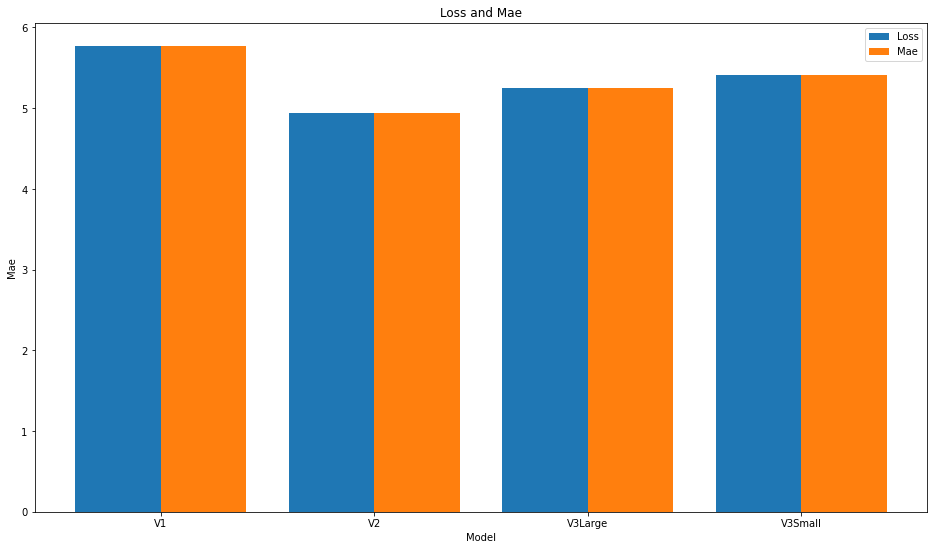

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

X = ['V1','V2','V3Large','V3Small']
Loss = np.array( [ loss_V1 , loss_V2 , loss_V3L , loss_V3S ] )
Mae = np.array( [ acc_V1 , acc_V2 , acc_V3L , acc_V3S ] )

X_axis = np.arange(len(X))
plt.figure(figsize=(16,9))  

plt.bar(X_axis - 0.2, Loss, 0.4, label = 'Loss')
plt.bar(X_axis + 0.2, Mae, 0.4, label = 'Mae')
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("Mae")
plt.title("Loss and Mae")
plt.legend()
plt.show()
#Best of value is 0

## Size of Model

In [ ]:
import os
def getsize_model(file_path):
    size_byte = os.path.getsize(file_path)
    size_KB = size_byte / 1024
    size_MB = size_KB / 1024
    return size_MB

In [ ]:
size_V1 = getsize_model(model_path/'MobileNetV1.h5') 
size_V2 = getsize_model(model_path/'MobileNetV2.h5') 
size_V3L = getsize_model(model_path/'MobileNetV3L.h5') 
size_V3S = getsize_model(model_path/'MobileNetV3S.h5') 

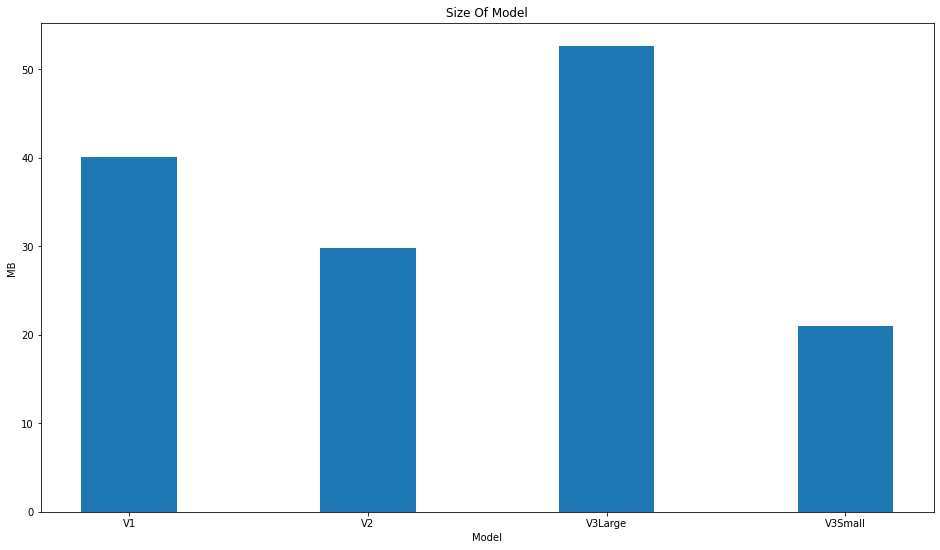

In [ ]:
X = ['V1','V2','V3Large','V3Small']
Y = np.array ( [ size_V1 , size_V2 , size_V3L , size_V3S ] )
X_axis = np.arange(len(X))
plt.figure(figsize=(16,9))  
plt.bar(X_axis , Y, 0.4)
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("MB")
plt.title("Size Of Model")
plt.show()

# API

In [ ]:
! pip install flask_cors

In [ ]:
!pip install flask-ngrok

In [ ]:
!pip install DeepFace

## Load Model

In [ ]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
from deepface import DeepFace
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
model = load_model(model_path/'MobileNetV2.h5')

## Predict Age

In [ ]:
groups_names= ['Children', 'Teenage', 'Youth', 'Middle', 'Old']
def predict_class(age):
    if age <= 10: return groups_names[0] #Children 0 - 10
    if age <= 18: return groups_names[1] #Teenage 10 - 18
    if age <= 34: return groups_names[2] #Youth   19 - 34
    if age <= 60: return groups_names[3] #Middle  35 - 60
    return groups_names[4]               #Old     61+
def preprocess_image(data):
    image = Image.fromarray(data, 'RGB')
    image = image.resize((224,224))
    image = np.array(image)
    image = np.expand_dims(image, axis = 0)
    return image
def detect_face(img_path):
    backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface']
    detected_face = DeepFace.detectFace( img_path , detector_backend=backends[2])
    return detected_face
def predict_age(image):
    input = preprocess_image(image)
    age = model.predict(input)
    return int(age), predict_class(age)

## Test

Text(0.5, 1.0, 'Age: 30 - Youth')

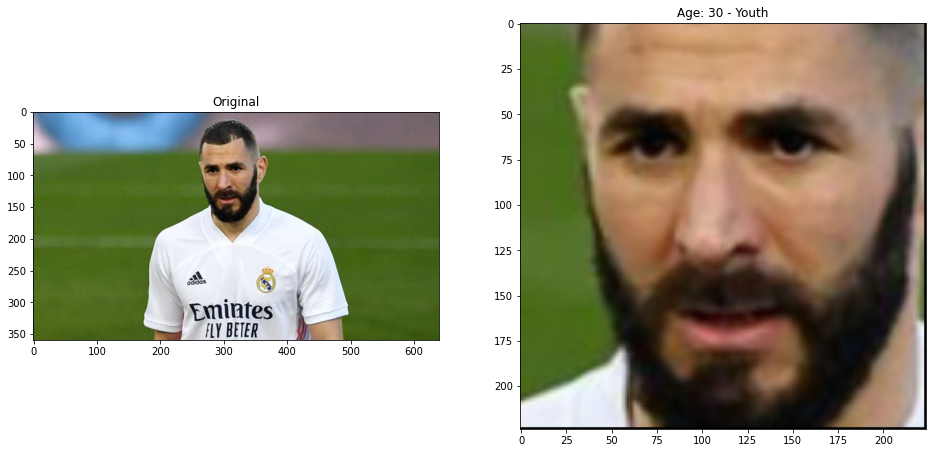

In [ ]:
# test = '/content/drive/MyDrive/FacialAge/Test_case/testcase2-18tuoi.png'
# test = '/content/drive/MyDrive/FacialAge/Test_case/testcase1-19tuoi.png'
# test = '/content/drive/MyDrive/FacialAge/Test_case/testcase4-21tuoi.png'
# test = '/content/drive/MyDrive/FacialAge/Test_case/testcase7-33tuoi.jpg'
test = '/content/drive/MyDrive/FacialAge/Test_case/testcase8-33tuoi.jpg'
# test = '/content/drive/MyDrive/FacialAge/Test_case/test2.jpg'
detected_face = detect_face(test)
age, age_class = predict_age(detected_face)
text = 'Age: '+ str(age) + ' - '+ age_class

plt.figure(figsize=(16,9))
ax = plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(test))
plt.title('Original')
ax = plt.subplot(1, 2, 2)
plt.imshow(detected_face)
plt.title(text)